# Training an Autonomous Taxi Agent

* Train a taxi agent to traverse a gridworld to pick up and drop off passengers using Q-learning
* <b>Agent</b>: Taxi-driver 
* <b>Environment (state space)</b>: = 500 discrete states
* <b>Environment Dynamics</b>:
    * Episode starts: Taxi starts at random square and passenger is at random location (R,G,B,Y)
    * Episode ends when the passenger is dropped off (or reaches a max of 200 steps per episode)
* <b>Reward</b>: 
    * -1 for every time-step
    * +20 points for successful drop off
    * -10 penalty for illegal pick up and drop off maneuvers 
* OpenAI gym: https://gym.openai.com/

In [36]:
import time
from datetime import date
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

try: 
    import gym # RL library to create environments
except:
    !pip install gym
    
from IPython.display import clear_output

print('Run Date: ', date.today())
#print('Associate: ', os.getlogin())

print('\n-------------- Dependencies --------------')
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Gym: ', gym.__version__)

Run Date:  2021-10-21

-------------- Dependencies --------------
Numpy:  1.19.5
Pandas:  1.3.3
Gym:  0.21.0


In [58]:
# Create Taxi environment provided by OpenAI gym 

env = gym.make('Taxi-v3')

### What is available to us in gym's environment?

Rendering:
- Blue: Passenger location
- Magenta: Drop-off location
- Yellow: Empty Taxi
- Green: Full Taxi
- Other letters: (R, G, Y and B): Locations for passengers and destinations

In [59]:
env.render() # show environment

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



<b>Passenger locations</b> (5):
- 0: R
- 1: G
- 2: Y
- 3: B
- 4: Inside Taxi

<b>Drop-off Locations</b> (4)
- 0: R
- 1: G
- 2: Y
- 3: B

<b>Taxi locations</b> (5x5 Grid) 

<b>Total Possible States</b> (500)
- ( Passenger locations * Drop-off Locations * Taxi Locations ) = ( 5 * 4 * 5 * 5 ) = 500 

### Environment

In [60]:
# Environment / State Space 

env.observation_space.n

500

### Actions

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

In [61]:
# Action space size

env.action_space.n

6

In [62]:
# Sample the action space and select random actions with equal probability 

env.action_space.sample()

5

### Rewards
- -1 reward per timestep
- +20 reward for successful dropoff 
- -10 penalty for illegal pickup and drop off maneuvers

In [63]:
current_state = env.reset() #reset environment (random) -- returns state
env.render() #render environment (current state)
print('Current state: ', current_state)

action = 0
next_state, reward, done, _ = env.step(action) # take action 0 (move south)
env.render() #render environment (next state)

print("Next state: ", next_state)
print("Reward: ", reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current state:  206
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Next state:  306
Reward:  -1


## Create an "dumb" agent that only selects random actions.

Agent is not trained to move intelligently through the environment.

Run 10 episodes of a randomly-acting agent and find the average reward

In [64]:
actions_dict = {0: 'Move South', 1: 'Move North', 2: 'Move East', 3: 'Move West', 4: 'Pickup Passenger' ,5: 'Dropoff Passenger'}
rewards_dict = {-10: 'Illegal Dropoff Move', -1: 'Single Step', 20: 'Successful Dropoff'}

In [65]:
episodes = 10 
episodes_total_reward = []
episodes_step_count = []

for episode in range(1, episodes + 1):
    
    orig_state = env.reset() # At the beginning of each episode, reset the environment to its starting state
    done = False 
    total_reward = 0 
    step_count = 0
    
    while not done: # Taxi moves until terminal state reached
        print('\n')
        env.render() 
        
        print('Episode: ', episode)
        
        action = env.action_space.sample() # uniform random action
        print('Selected Action: ', action, '-', actions_dict[action])
        next_state, reward, done, info = env.step(action) # Use the action to determine the next state, reward associated with the action, and if the next state is terminal
        print('Next State: ', next_state)
        print('Step Reward: ', reward, '-', rewards_dict[reward])
        print('Total Reward: ', total_reward)
        print('Is terminal?: ', done)
        total_reward += reward # Store the episode reward
        step_count += 1 
        
        clear_output(wait=True)
    
    print('************************************************************************')
    print(f'Episode {episode}, completed with total reward: {total_reward}')
    print('************************************************************************')
    
    episodes_total_reward.append(total_reward)
    episodes_step_count.append(step_count)

env.close()

clear_output(wait=True)
print('************************************************************************')
print('Episode Rewards: ', episodes_total_reward)
print('Episode Steps Taken: ', episodes_step_count)
print('Average reward over 10 episodes = ', np.average(episodes_total_reward))
print('************************************************************************')

************************************************************************
Episode Rewards:  [-758, -677, -839, -623, -758, -776, -749, -812, -713, -812]
Episode Steps Taken:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Average reward over 10 episodes =  -751.7
************************************************************************


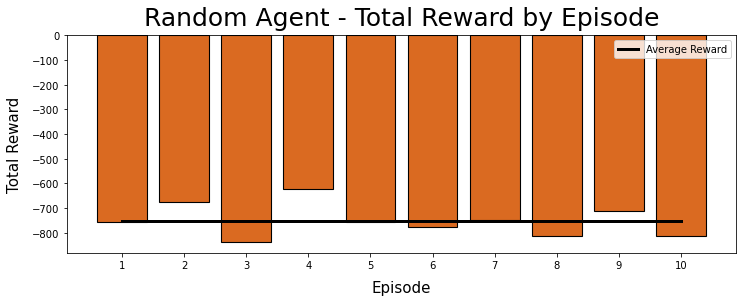

In [66]:
# Plot the total reward by episode with "dumb" agent

plt.figure(figsize=(12,4))
sns.barplot(x = np.arange(1,11), y = episodes_total_reward, color='#F96302', edgecolor='black', linewidth=1.1) 
sns.lineplot(x = np.arange(0,10), y = np.average(episodes_total_reward), color='black', linewidth=3, label='Average Reward')
plt.xlabel('Episode',size=15,labelpad=10)
plt.ylabel('Total Reward',size=15,labelpad=10)
plt.title('Random Agent - Total Reward by Episode',size=25, pad=10)
plt.legend(loc=1)
plt.show()

# Train an Intelligent Agent using the Q-Learning Algorithm

<b>Learn values of Q-table through the agent interacting (trial & error) with the environment</b>

* Q-tables are like a <b>cheatsheet</b> of what action to choose that most likely have the highest expected reward
* Table is size [state, action]
    * state = rows
    * columns = actions
* Table values = expected discounted reward for choosing an action given a state
* Q-tables have difficulty scaling in situations where state/action spaces are large 

### Q-Learning Algorithm Process: 

1. Initialize Q-table (rows = # states, columns = # actions, values = 0)
2. Choose an action
3. Perform the action & measure reward
4. Update Q-table

In [67]:
# STEP 1: Initalize the Q-table (with zeros for values of reward)

actions = env.action_space.n
states = env.observation_space.n

q_table = np.zeros((states, actions)) 
q_table.shape

(500, 6)

In [68]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## Bellman Equation
* As the agent traverses the environment, it will take actions and receive rewards from the environment
* Use the Bellman equation to iteratively update the values of the Q-table
* As the agent continues to interact with environment we get closer to converging to the <b>optimal policy</b>

In [69]:
def bellman_equation(q_table, state, action, learning_rate, reward, discount_rate, new_state):
    '''
    Returns newly calculated q-value for state and action q(s,a) using learning rate
    
    q_table: current q_table and values
    reward: scalar value received from environment after taking action
    learning_rate: helps you choose if you want to more highly weight the old q-value vs. the new q-value
        Higher the learning rate the more quickly the agent will adopt the newly computed Q-value
    discount_rate: How much we penalize future rewards (0 = myopic, 1 = no discount)
    '''
    
    return (1-learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))  

## Exploration vs. Exploitation Trade-off
* Tradeoff between taking action with highest reward or exploring environment via random action
* Better to explore heavily at first then exploit later
* Declay exploration rate (epsilon) over time
* <b>Epsilon greedy</b>
    * Variable epsilon
    * Take random action with probability epsilon, otherwise take action with highest reward 

In [70]:
def decay_exploration_rate(min_exploration_rate, max_exploration_rate, exploration_decay_rate, episode):
    '''
    Method to reduce (decay) the rate that we explore (take random actions) in later episodes
    '''
    return min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode) 

### Train our Agent on 6,000 episodes

In [71]:
# Parameters for Q-learning
num_episodes = 6000 
max_steps_per_episode = 100 

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1 
max_exploration_rate = 1 
min_exploration_rate = 0.01
exploration_decay_rate = 0.001 

# Store all episodes metrics 
episodes_total_reward = []
episodes_exploration_rate = []

# Q-Learning Algorithm
for episode in range(num_episodes):
    
    state = env.reset()
    done = False 
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        
  
        # STEP 2: Use Epsilon greedy method to choose an action
        if random.uniform(0,1) > exploration_rate: # randomly choose a random number between 0 - 1 with equal probability
            action = np.argmax(q_table[state, :]) # Act greedily - choose the best action given the state 
        else:
            action = env.action_space.sample() # Explore - choose random action
            
        # STEP 3: Perform the chosen Action and Measure the Reward
        new_state, reward, done, info = env.step(action)
        
        # STEP 4: Update the q-table using the Bellman Equation 
        q_table[state, action] = bellman_equation(q_table, state, action, learning_rate, reward, discount_rate, new_state)

        state = new_state 
        total_reward += reward
        
        if done: # if we dropped off passenger break loop 
            break 
    
    # store episode information
    episodes_total_reward.append(total_reward)
    episodes_exploration_rate.append(exploration_rate)
    
    # decay the exploration rate for the next episode
    exploration_rate = decay_exploration_rate(min_exploration_rate, max_exploration_rate, exploration_decay_rate, episode)
    
    
print('************************************************************************')
print('Average reward over 10 episodes = ', np.average(episodes_total_reward[-10:]))
print('************************************************************************')       

************************************************************************
Average reward over 10 episodes =  6.9
************************************************************************


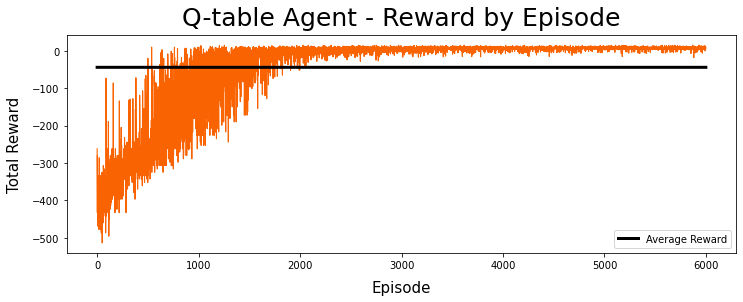

In [72]:
plt.figure(figsize=(12,4))
sns.lineplot(x = np.arange(0,len(episodes_total_reward)), y = episodes_total_reward, color='#F96302', linewidth=1.1) 
sns.lineplot(x = np.arange(0,len(episodes_total_reward)), y = np.average(episodes_total_reward), color='black', linewidth=3, label='Average Reward')
plt.xlabel('Episode',size=15,labelpad=10)
plt.ylabel('Total Reward',size=15,labelpad=10)
plt.title('Q-table Agent - Reward by Episode',size=25, pad=10)
plt.legend(loc=4)
plt.show()

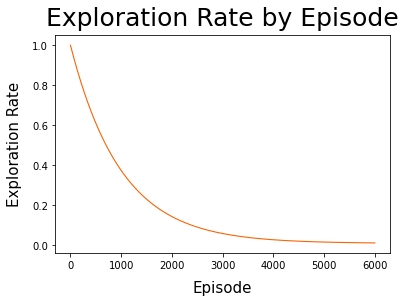

In [73]:
plt.figure(figsize=(6,4))
sns.lineplot(x = np.arange(0,len(episodes_exploration_rate)), y = episodes_exploration_rate, color='#F96302', linewidth=1.1) 
plt.xlabel('Episode',size=15,labelpad=10)
plt.ylabel('Exploration Rate',size=15,labelpad=10)
plt.title('Exploration Rate by Episode',size=25, pad=10)
plt.show()

### Visualize the Trained/Intelligent Agent run through 3 episodes  

In [74]:
for episode in range(3):
    state = env.reset()
    done = False 
    print('EPISODE: ', str(episode + 1)) 
    time.sleep(1)
    
    for step in range(max_steps_per_episode):
        clear_output(wait=True)
        env.render()
        time.sleep(0.4)
        
        action = np.argmax(q_table[state, :]) # get the best action 
        
        new_state, reward, done, info = env.step(action)
                
        if done:
            clear_output(wait=True)
            env.render() 
            
            if reward == 20:  # 20 indicates a successful pickup and drop off 
                print('***************************************************************************************************')
                print('                      Successfully picked up and dropped off passenger                             ')
                print('***************************************************************************************************')
                time.sleep(2)
                clear_output(wait=True)
            else:
                print('***************************************************************************************************')
                print('                                           FAILED                                                  ')
                print('***************************************************************************************************')
                time.sleep(2)
                clear_output(wait=True)
            
            break
        
        state = new_state 

env.close()
            

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
***************************************************************************************************
                      Successfully picked up and dropped off passenger                             
***************************************************************************************************


# Try on your own:

What do you expect will happen if you: 

* Try decreasing the discount rate
* Try increasing the learning rate
* Try increasing or decreasing the exploration decay rate


# Resources
* Getting started with Gym: https://gym.openai.com/docs/
* Udemy - Practical Reinforcement Learning using Python ($): 
* Github for Taxi-v3 environment: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://www.analyticsvidhya.com/blog/2021/02/understanding-the-bellman-optimality-equation-in-reinforcement-learning